In [1]:
import torch
import torch.nn as nn
import torchtext
from torchtext import data
from torchtext.datasets import text_classification
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os
from transformers import BertTokenizer, BertConfig, BertModel, BertForMaskedLM, BertForSequenceClassification

/home/haiming/fast_hm/anaconda3/envs/py3.6_pt1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/haiming/fast_hm/anaconda3/envs/py3.6_pt1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/haiming/fast_hm/anaconda3/envs/py3.6_pt1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
pretrained_bert='bert-base-uncased'
bert_cache_dir='~/.pytorch_pretrained_bert/'
save_folder = 'model/'

In [4]:
Dataset_name = 'AG_NEWs'

In [5]:
train_raw = pd.read_csv('../data/ag_news_csv/train.csv', names=['Class Index', 'Title', 'Description'])
test_raw = pd.read_csv('../data/ag_news_csv/test.csv', names=['Class Index', 'Title', 'Description'])

In [6]:
train_raw

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

I1125 13:51:30.698855 140364364490496 tokenization_utils.py:373] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/haiming/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [12]:
def _del_by_idx(array_list, idx, axis):
    '''
        Delete the specified index for each array in the array_lists

        @params: array_list: list of np arrays
        @params: idx: list of int
        @params: axis: int

        @return: res: tuple of pruned np arrays
    '''
    if type(array_list) is not list:
        array_list = [array_list]

    # modified to perform operations in place
    for i, array in enumerate(array_list):
        array_list[i] = np.delete(array, idx, axis)

    if len(array_list) == 1:
        return array_list[0]
    else:
        return array_list

def process_data(data, Dataset_name, tokenizer, Extra_label=False, EXTRA_TOKEN=None):
    print("add extra label: ", Extra_label)
    print("extra label: ", EXTRA_TOKEN)
    if Dataset_name=='AG_NEWs':
        title = data['Title'].tolist()
        des = data['Description'].tolist()
        label = data['Class Index'].tolist()
        token_id = []
        max_len = 0
        import ipdb; ipdb.set_trace()
        for i in range(len(des)):
            comb_text = title[i] + " " + des[i]
            token_id.append(tokenizer.encode(comb_text, add_special_tokens=False))
            max_len = max(len(token_id[i]),max_len)
        
        del_idx = []
        ex_len = 0
        # convert each token to its corresponding id
        if Extra_label == True:
            print("add extra label: ", EXTRA_TOKEN)
            ex_token = EXTRA_TOKEN
            text_label = np.zeros([1], dtype=np.int64)
            text_label[0] = tokenizer.encode(ex_token,add_special_tokens=False)[0]
#             text_label[1] = 102
            ex_len = len(text_label)
        
        max_len = max_len+ex_len
        text_len = np.array([len(tok) for tok in token_id])
        text = np.zeros((len(data),max_len), dtype=np.int64)
        
        for i in range(len(data)):
            text[i, :len(token_id[i])] = token_id[i]
            if Extra_label:
                text[i, len(token_id[i]):len(token_id[i])+ex_len] = text_label
                text_len[i] = text_len[i] + ex_len

            # filter out document with only special tokens
            # unk (100), cls (101), sep (102), pad (0)
            if np.max(text[i]) < 103:
                del_idx.append(i)
#         print(text[0])
#         print(text[0])
    else:
        text_len = None
        text = None
        label = None
        del_idx = None
#     print(max_len)
    text_len, text, label= _del_by_idx([text_len, text, label], del_idx, 0)
    new_data = {
        'token_id': text,
        'token_len': text_len,
        'label': label
    }
    return new_data

In [ ]:
def process_data2(data, Dataset_name, tokenizer, Extra_label=False, EXTRA_TOKEN_LIST=None):
    print("add extra label: ", Extra_label)
    print("extra label: ", EXTRA_TOKEN_LIST)
    if Dataset_name=='AG_NEWs':
        title = data['Title'].tolist()
        des = data['Description'].tolist()
        label = data['Class Index'].tolist()
        token_id = []
        max_len = 0
        for i in range(len(des)):
            comb_text = title[i] + " " + des[i]
            token_id.append(tokenizer.encode(comb_text, add_special_tokens=True))
            max_len = max(len(token_id[i]),max_len)
        
        del_idx = []
        ex_len = 0
        # convert each token to its corresponding id
        EMBEDDING_EXTRA_TOKEN_LIST = []
        if Extra_label == True:
#             print("add extra label: ", EXTRA_TOKEN)
            for ex_token in  EXTRA_TOKEN_LIST: 
#                 text_label = []
#                 text_label.append( tokenizer.encode(ex_token+'[SEP]',add_special_tokens=False))
#                 print("token!!!")
#                 print(tokenizer.encode(ex_token+'[SEP]',add_special_tokens=False))
#                 text_label.append (102)
                text_label = tokenizer.encode(ex_token+'[SEP]',add_special_tokens=False)
                EMBEDDING_EXTRA_TOKEN_LIST.append(text_label)
                if len(text_label) > ex_len:
                    ex_len = len(text_label)
        
        max_len = max_len+ex_len
        text_len = np.array([len(tok) for tok in token_id])
        text = np.zeros((len(data),max_len), dtype=np.int64)
        
        
        print("="*20)
        print(EMBEDDING_EXTRA_TOKEN_LIST)
        for i in range(len(data)):
            text[i, :len(token_id[i])] = token_id[i]
            if Extra_label:
#                 print(int(label(i))+1)

                text[i, len(token_id[i]):len(token_id[i])+len(EMBEDDING_EXTRA_TOKEN_LIST[int(label[i])-1])] = EMBEDDING_EXTRA_TOKEN_LIST[int(label[i])-1]
                text_len[i] = text_len[i] + ex_len

            # filter out document with only special tokens
            # unk (100), cls (101), sep (102), pad (0)
            if np.max(text[i]) < 103:
                del_idx.append(i)
#         print(text[0])
        print(text)
    else:
        text_len = None
        text = None
        label = None
        del_idx = None
    print(max_len)
    text_len, text, label= _del_by_idx([text_len, text, label], del_idx, 0)
    new_data = {
        'token_id': text,
        'token_len': text_len,
        'label': label
    }
    return new_data

In [9]:
print(train_raw['Class Index'].tolist()[1])

3


In [13]:
train_data = process_data(train_raw, Dataset_name, tokenizer, True, EXTRA_TOKEN)

add extra label:  True
extra label:  NEWS
> <ipython-input-12-b85b5b59cf03>(33)process_data()
     32         import ipdb; ipdb.set_trace()
---> 33         for i in range(len(des)):
     34             comb_text = title[i] + " " + des[i]

ipdb> l
     28         des = data['Description'].tolist()
     29         label = data['Class Index'].tolist()
     30         token_id = []
     31         max_len = 0
     32         import ipdb; ipdb.set_trace()
---> 33         for i in range(len(des)):
     34             comb_text = title[i] + " " + des[i]
     35             token_id.append(tokenizer.encode(comb_text, add_special_tokens=False))
     36             max_len = max(len(token_id[i]),max_len)
     37 
     38         del_idx = []

ipdb> n
> <ipython-input-12-b85b5b59cf03>(34)process_data()
     33         for i in range(len(des)):
---> 34             comb_text = title[i] + " " + des[i]
     35             token_id.append(tokenizer.encode(comb_text, add_special_tokens=False))

ipdb> n

ipdb> n
add extra label:  NEWS
> <ipython-input-12-b85b5b59cf03>(43)process_data()
     42             print("add extra label: ", EXTRA_TOKEN)
---> 43             ex_token = EXTRA_TOKEN
     44             text_label = np.zeros([1], dtype=np.int64)

ipdb> n
> <ipython-input-12-b85b5b59cf03>(44)process_data()
     43             ex_token = EXTRA_TOKEN
---> 44             text_label = np.zeros([1], dtype=np.int64)
     45             text_label[0] = tokenizer.encode(ex_token,add_special_tokens=False)[0]

ipdb> n
> <ipython-input-12-b85b5b59cf03>(45)process_data()
     44             text_label = np.zeros([1], dtype=np.int64)
---> 45             text_label[0] = tokenizer.encode(ex_token,add_special_tokens=False)[0]
     46 #             text_label[1] = 102

ipdb> n
> <ipython-input-12-b85b5b59cf03>(47)process_data()
     46 #             text_label[1] = 102
---> 47             ex_len = len(text_label)
     48 

ipdb> text)label
*** SyntaxError: invalid syntax
ipdb> text_label
array([2739]

ipdb> n
> <ipython-input-12-b85b5b59cf03>(61)process_data()
     60             # unk (100), cls (101), sep (102), pad (0)
---> 61             if np.max(text[i]) < 103:
     62                 del_idx.append(i)

ipdb> n
> <ipython-input-12-b85b5b59cf03>(53)process_data()
     52 
---> 53         for i in range(len(data)):
     54             text[i, :len(token_id[i])] = token_id[i]

ipdb> text[0]
array([ 2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
        1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,
        2813,  2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,
        1997, 11087,  1011, 22330,  8713,  2015,  1010,  2024,  3773,
        2665,  2153,  1012,  2739,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0

BdbQuit: 

In [10]:
Extra_label = True
EXTRA_TOKEN = "NEWS"
# EXTRA_TOKEN_LIST = ['World', 'Sports', 'Business', 'Sci/Tech']
# EXTRA_TOKEN_LIST=[]
train_data = process_data(train_raw, Dataset_name, tokenizer, True, EXTRA_TOKEN)
test_data = process_data(test_raw, Dataset_name, tokenizer,True ,EXTRA_TOKEN)

add extra label:  True
extra label:  NEWS
add extra label:  NEWS
add extra label:  True
extra label:  NEWS
add extra label:  NEWS


In [34]:
train_data['token_id'].shape

(120000, 378)

In [14]:
all_classes = np.unique(test_data['label'])

In [15]:
print(all_classes)

[1 2 3 4]


In [16]:
train_data['label']

array([3, 3, 3, ..., 2, 2, 2])

In [17]:
train_idx_list=[]
for y in all_classes:
    train_idx_list.append(np.squeeze(np.argwhere(train_data['label'] == y)))

In [18]:
print(train_idx_list)

[array([   492,    493,    494, ..., 119993, 119994, 119995]), array([   448,    449,    450, ..., 119997, 119998, 119999]), array([     0,      1,      2, ..., 119979, 119980, 119981]), array([    78,     79,     80, ..., 119951, 119952, 119954])]


In [19]:
validation_split = 0.01
num_all_per_class = len(train_idx_list[0])
print(num_all_per_class)
num_train_per_class = 5
num_val_per_class = 2000
num_labels = len(all_classes)
shuffle_dataset = True
random_seed= 514
training_batch_size=4
testing_batch_size=64
num_epochs = 10

30000


In [20]:
len(train_data['label'])

120000

In [21]:
indices = list(range(num_all_per_class))
if shuffle_dataset:
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
train_indices, val_indices = [], []
for i in range(num_labels):
    np.random.shuffle(train_idx_list[i])
    train_indices.extend(train_idx_list[i][:num_train_per_class].tolist())
#     print(train_idx_list[i][:num_train_per_class])
    val_indices.extend(train_idx_list[i][num_train_per_class:num_train_per_class+num_val_per_class].tolist())
#    print(train_idx_list[i][num_train_per_class:num_train_per_class+num_val_per_class])
#    print("----")

In [22]:
print(train_indices[0:20])
print(val_indices[0:20])

[5895, 112547, 71185, 70714, 74512, 41251, 98814, 22152, 26665, 113135, 77221, 109378, 66452, 75811, 32262, 41794, 19814, 29400, 23483, 101007]
[37734, 102950, 45907, 95151, 6568, 92291, 3596, 38794, 53125, 30289, 30472, 102545, 34899, 12872, 19562, 42315, 7085, 30868, 29535, 10028]


In [152]:
# CLASS

In [23]:
label = 0
for i in range(len(train_indices)):
    if i % num_train_per_class == 0:
        label = label +1
    idx = train_indices[i]
    if train_data['label'][idx] != label:
        print(idx)
        print(label)
        print(train_data['label'][idx])

In [24]:
label = 0
for i in range(len(val_indices)):
    if i % num_val_per_class == 0:
        label = label +1
    idx = val_indices[i]
    if train_data['label'][idx] != label:
        print(idx)
        print(label)
        print(train_data['label'][idx])

In [155]:
# Creating data indices for training and validation splits:
# dataset_size = len(train_data['token_id'])
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[:split], indices[split:split*8]

In [25]:
print("Num of training data: ", len(train_indices))
print("Num of validation data: ", len(val_indices))

Num of training data:  20
Num of validation data:  8000


In [26]:
test_indices = list(range(len(test_data['token_id'])))

In [27]:
print("Num of test data: ", len(test_indices))

Num of test data:  7600


In [28]:
class myDataset(data.Dataset):
    def __init__(self, datasource):
        self.data = datasource['token_id']
        self.data_len = datasource['token_len']
        self.label = datasource['label']
    
    def __getitem__(self, index):
        data_ts = torch.tensor(self.data[index], dtype=torch.long)
        data_len_ts = torch.tensor(self.data_len[index], dtype=torch.long)
        label_ts = torch.tensor(self.label[index], dtype=torch.long)-1
        return data_ts, data_len_ts, label_ts
    
    def __len__(self):
        return len(self.data)

In [29]:
train_dataset = myDataset(train_data)
test_dataset = myDataset(test_data)

In [30]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=training_batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=testing_batch_size,
                                                sampler=valid_sampler)
testing_loader = torch.utils.data.DataLoader(test_dataset, batch_size=testing_batch_size,
                                                sampler=test_sampler)

In [35]:
len(training_loader)
len(validation_loader)

125

In [36]:
125*64

8000

In [32]:
class TextModel(nn.Module):
    def __init__(self, config, num_labels, pretrained_model_name_or_path, cache_dir):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name_or_path, cache_dir=cache_dir,config = config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.num_labels = num_labels
    
    def forward(self, token_id, text_len, labels=None):
        len_range = torch.arange(token_id.size()[-1], device=token_id.device,
                                 dtype=text_len.dtype).expand(*token_id.size())
        mask1 = (len_range < text_len.unsqueeze(-1)).long()
        out = self.bert(token_id, attention_mask=mask1)
#         print(len(out))
        
#         pooled_output = out[1]

        output = self.dropout(torch.mean(out[0],dim = 1))
        logits = self.classifier(output)
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss, logits

In [33]:

# Save and Load Functions

def save_checkpoint(save_path, model, valid_acc):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_acc': valid_acc}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_acc']


def save_metrics(save_path, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'train_acc_list': train_acc_list,
                  'valid_loss_list': valid_loss_list,
                  'valid_acc_list': valid_acc_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['train_acc_list'], state_dict['valid_loss_list'], state_dict['valid_acc_list'], state_dict['global_steps_list']

In [165]:
def train(model, optimizer, 
          train_loader=training_loader, 
          valid_loader=validation_loader, 
          num_epochs=num_epochs,
          eval_every = len(training_loader),
          file_path = save_folder,
          best_valid_acc = 0.0):
    running_loss = 0.0
    valid_running_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    train_acc_list = []
    valid_acc_list = []
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    # training loop
    model.train()
    for epoch in range(num_epochs):
        for idx, data in enumerate(train_loader):
#             print(data[0][0][:data[1][0]+1])
#             print(data[1])
#             print(data[2])
            token_id = data[0].to(device)
            token_len = data[1].to(device)
            label = data[2].to(device)
            loss, logits = model(token_id, token_len, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += (logits.argmax(1)==label).sum().item()/training_batch_size
            # update running values
            running_loss += loss.item()
            global_step += 1
            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                    # validation loop
                    for idx, val_data in enumerate(valid_loader):
                        token_id = val_data[0].to(device)
                        token_len = val_data[1].to(device)
                        label = val_data[2].to(device)
                        loss, logits = model(token_id, token_len, label)
                        valid_running_loss += loss.item()
                        valid_acc += (logits.argmax(1)==label).sum().item()/testing_batch_size
                # evaluation
                average_train_loss = running_loss / eval_every
                average_train_acc = train_acc / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                average_valid_acc = valid_acc / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                train_acc_list.append(average_train_acc)
                valid_acc_list.append(average_valid_acc)
                global_steps_list.append(global_step)
                
                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                train_acc = 0.0
                valid_acc = 0.0
                model.train()
                
                 # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f},'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_train_acc, average_valid_loss, average_valid_acc))
                # checkpoint
                if best_valid_acc < average_valid_acc:
                    best_valid_acc = average_valid_acc
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_acc)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, global_steps_list)

    print('Finished Training!')

In [166]:
config = BertConfig()
config.output_attentions=True
model = TextModel(config, 4, pretrained_bert, bert_cache_dir).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [167]:
train(model=model, optimizer=optimizer)

Epoch [1/10], Step [5/50], Train Loss: 1.4692, Train Acc: 0.2500, Valid Loss: 1.3864, Valid Acc: 0.3290,
Model saved to ==> model//model.pt
Model saved to ==> model//metrics.pt
Epoch [2/10], Step [10/50], Train Loss: 1.1975, Train Acc: 0.7500, Valid Loss: 1.3346, Valid Acc: 0.4551,
Model saved to ==> model//model.pt
Model saved to ==> model//metrics.pt
Epoch [3/10], Step [15/50], Train Loss: 1.0649, Train Acc: 0.9500, Valid Loss: 1.2746, Valid Acc: 0.5310,
Model saved to ==> model//model.pt
Model saved to ==> model//metrics.pt
Epoch [4/10], Step [20/50], Train Loss: 0.8255, Train Acc: 1.0000, Valid Loss: 1.1869, Valid Acc: 0.5487,
Model saved to ==> model//model.pt
Model saved to ==> model//metrics.pt
Epoch [5/10], Step [25/50], Train Loss: 0.5474, Train Acc: 0.9500, Valid Loss: 1.0734, Valid Acc: 0.5942,
Model saved to ==> model//model.pt
Model saved to ==> model//metrics.pt
Epoch [6/10], Step [30/50], Train Loss: 0.3637, Train Acc: 1.0000, Valid Loss: 0.9418, Valid Acc: 0.6369,
Model

Model loaded from <== model//metrics.pt


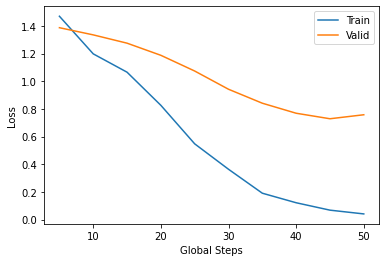

In [168]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, global_steps_list = load_metrics(save_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

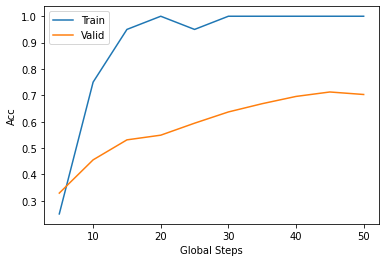

In [169]:
plt.plot(global_steps_list, train_acc_list, label='Train')
plt.plot(global_steps_list, valid_acc_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Acc')
plt.legend()
plt.show() 

In [170]:
print("Train lost list: ", train_loss_list)
print("Train acc list: ", train_acc_list)
print("Valid lost list: ", valid_loss_list)
print("Valid acc list: ", valid_acc_list)
print("Global Steps: ", global_steps_list)

Train lost list:  [1.4692075967788696, 1.1974626541137696, 1.0649476528167725, 0.825523579120636, 0.5474028170108796, 0.3637000501155853, 0.19068666100502013, 0.12180139422416687, 0.06825977563858032, 0.04109907150268555]
Train acc list:  [0.25, 0.75, 0.95, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0]
Valid lost list:  [1.3864139890670777, 1.3346082487106323, 1.2746286602020265, 1.1869456901550293, 1.0734350104331971, 0.9417500152587891, 0.8408739228248596, 0.7684698657989502, 0.7286154608726502, 0.7574975590705871]
Valid acc list:  [0.329, 0.455125, 0.531, 0.54875, 0.59425, 0.636875, 0.66825, 0.69575, 0.712625, 0.703125]
Global Steps:  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


In [171]:
target_names = ['World', 'Sports', 'Business', 'Sci/Tech']

In [172]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            token_id = data[0].to(device)
            token_len = data[1].to(device)
            label = data[2].to(device)
            loss, logits = model(token_id, token_len, label)

            y_pred.extend(torch.argmax(logits, 1).tolist())
            y_true.extend(label.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names)
    

Model loaded from <== model//model.pt
Classification Report:
              precision    recall  f1-score   support

       World     0.6793    0.7947    0.7325      1900
      Sports     0.9210    0.8342    0.8754      1900
    Business     0.5614    0.7747    0.6510      1900
    Sci/Tech     0.8588    0.4674    0.6053      1900

    accuracy                         0.7178      7600
   macro avg     0.7551    0.7178    0.7161      7600
weighted avg     0.7551    0.7178    0.7161      7600



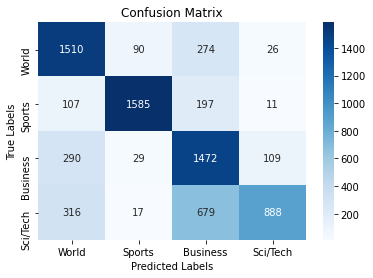

In [173]:
best_model = TextModel(config, 4, pretrained_bert, bert_cache_dir).to(device)

load_checkpoint(save_folder + '/model.pt', best_model)

evaluate(best_model, testing_loader)

In [69]:
#Credits to Lin Zhouhan(@hantek) for the complete visualization code
import random, os, numpy, scipy
from codecs import open
def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
	weights: attention weights for visualizing
	texts: text on which attention weights are to be visualized
    """
    fileName = "visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="en">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = "";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>" + space + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return


In [62]:
text1 = "[CLS]Apple Tops in Customer Satisfaction,Dell comes in a close second, while Gateway shows improvement, study says.[SEP]"
tok = tokenizer.tokenize(text1)

In [ ]:
p_pos = len(tok1)

In [ ]:
config

In [72]:
createHTML([text1],[attentions[11,3,0,:].numpy().tolist()],'attention2.html')

In [ ]:
attentions = torch.cat(output[2]).to('cpu')
attentions.shape 

In [13]:
text2 = 'NEWS'
p_pos = len(tok1)
tok2 = tokenizer.tokenize(text2)
tok = tok1+tok2

In [63]:
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')

with torch.no_grad():
    output = best_model.bert(ids)
attentions = torch.cat(output[2]).to('cpu')
attentions.shape

torch.Size([12, 12, 23, 23])

In [ ]:
layers = len(attentions[0][0])
heads = len(attentions[0])
seqlen = len(attentions)

In [ ]:
attentions = attentions.permute(2,1,0,3)
attentions_pos = attentions[p_pos]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cols = 2
rows = int(heads/cols)

fig, axes = plt.subplots( rows,cols, figsize = (14,40))
axes = axes.flat
print (f'Attention weights for token {tok[p_pos]}')
for i,att in enumerate(attentions_pos):

    #im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok)
    axes[i].set_title(f'head - {i} ' )
    axes[i].set_ylabel('layers')

In [ ]:
fig2, ax2 = plt.subplots(figsize=(30,11))
avg_attention = attentions_pos.mean(dim = 0)
sns.heatmap(avg_attention,vmin = 0, vmax = 1, xticklabels= tok,ax=ax2)

In [ ]:
from bertviz import head_view


In [ ]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

In [ ]:
def show_head_view(model, tokenizer, sentence_a, sentence_b=None):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids.to('cuda'), token_type_ids=token_type_ids.to('cuda'))[-1]
        sentence_b_start = token_type_ids[0].tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)    
    head_view(attention, tokens, sentence_b_start)

In [ ]:
from bertviz.neuron_view import show
model_type = 'bert'

In [ ]:
sentence_a = "Linksys will provide broadband-to-phone adapters and, eventually, Wi-Fi equipment."
sentence_b = "technology"
# show(best_model.bert, model_type, tokenizer, sentence_a, sentence_b)
show_head_view(best_model.bert, tokenizer, sentence_a, sentence_b)